In [1]:
!pip install matplotlib

  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 50.0 MB/s eta 0:00:00
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 38.3 MB/s eta 0:00:00
Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl (64 kB)
Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl (4.7 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import numpy as np
from typing import Dict, List, Any, Tuple

def plot_gepa_evolution_tree(optimized_results_dict: Dict[str, Any], 
                           figsize: Tuple[int, int] = (15, 10),
                           save_path: str = None,
                           title: str = "GEPA Evolution Tree") -> plt.Figure:
    """
    Plot GEPA evolution tree similar to the React EvolutionTree component.
    
    Args:
        optimized_results_dict: Dictionary from optimized_results.to_dict()
        figsize: Figure size tuple (width, height)
        save_path: Optional path to save the plot
        title: Title for the plot
        
    Returns:
        matplotlib Figure object
    """
    
    # Extract data from GEPA results
    candidates = optimized_results_dict['candidates']
    parents = optimized_results_dict['parents']
    scores = optimized_results_dict['val_aggregate_scores']
    best_idx = optimized_results_dict['best_idx']
    
    # Build node data structure
    nodes = []
    for i, (candidate, parent_list, score) in enumerate(zip(candidates, parents, scores)):
        prompt = candidate.get('instruction_prompt', '')
        parent_idx = parent_list[0] if parent_list and parent_list[0] is not None else None
        
        node = {
            'id': i,
            'score': score,
            'prompt': prompt,
            'prompt_length_chars': len(prompt),
            'prompt_length_words': len(prompt.split()),
            'parent_idx': parent_idx,
            'is_best': i == best_idx,
            'level': 0  # Will be calculated
        }
        nodes.append(node)
    
    # Calculate levels (depth in tree)
    def calculate_level(node_id, nodes, memo={}):
        if node_id in memo:
            return memo[node_id]
        
        node = nodes[node_id]
        if node['parent_idx'] is None:
            level = 0
        else:
            level = calculate_level(node['parent_idx'], nodes, memo) + 1
        
        memo[node_id] = level
        node['level'] = level
        return level
    
    for node in nodes:
        calculate_level(node['id'], nodes)
    
    # Group nodes by level
    levels = {}
    for node in nodes:
        level = node['level']
        if level not in levels:
            levels[level] = []
        levels[level].append(node['id'])
    
    # Build edges
    edges = []
    for node in nodes:
        if node['parent_idx'] is not None:
            parent_score = nodes[node['parent_idx']]['score']
            edge = {
                'from': node['parent_idx'],
                'to': node['id'],
                'score_delta': node['score'] - parent_score
            }
            edges.append(edge)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    
    # Layout parameters
    level_height = 3.0
    node_width = 2.0
    node_height = 1.2
    margin = 1.0
    
    max_level = max(levels.keys())
    max_nodes_per_level = max(len(level_nodes) for level_nodes in levels.values())
    
    # Calculate positions for each node
    node_positions = {}
    for level, node_ids in levels.items():
        y = max_level * level_height - level * level_height  # Top to bottom
        
        # Center nodes horizontally
        total_width = len(node_ids) * node_width + (len(node_ids) - 1) * margin
        start_x = -total_width / 2
        
        for i, node_id in enumerate(node_ids):
            x = start_x + i * (node_width + margin) + node_width / 2
            node_positions[node_id] = (x, y)
    
    # Draw edges first (so they appear behind nodes)
    for edge in edges:
        from_pos = node_positions[edge['from']]
        to_pos = node_positions[edge['to']]
        
        # Draw line
        color = '#4caf50' if edge['score_delta'] >= 0 else '#f44336'
        linewidth = min(abs(edge['score_delta']) * 20 + 1, 8)  # Scale line width with score change
        alpha = 0.7
        
        ax.plot([from_pos[0], to_pos[0]], 
                [from_pos[1] - node_height/2, to_pos[1] + node_height/2], 
                color=color, linewidth=linewidth, alpha=alpha, zorder=1)
        
        # Add score delta label
        mid_x = (from_pos[0] + to_pos[0]) / 2
        mid_y = (from_pos[1] - node_height/2 + to_pos[1] + node_height/2) / 2
        
        delta_text = f"+{edge['score_delta']:.3f}" if edge['score_delta'] >= 0 else f"{edge['score_delta']:.3f}"
        ax.text(mid_x, mid_y, delta_text, 
                ha='center', va='center', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none'),
                zorder=3)
    
    # Draw nodes
    for node in nodes:
        pos = node_positions[node['id']]
        x, y = pos
        
        # Node styling
        if node['is_best']:
            facecolor = '#fff3e0'
            edgecolor = '#ff9800'
            linewidth = 3
        else:
            facecolor = '#f5f5f5'
            edgecolor = '#ddd'
            linewidth = 1
        
        # Draw node rectangle
        rect = FancyBboxPatch(
            (x - node_width/2, y - node_height/2),
            node_width, node_height,
            boxstyle="round,pad=0.1",
            facecolor=facecolor,
            edgecolor=edgecolor,
            linewidth=linewidth,
            zorder=2
        )
        ax.add_patch(rect)
        
        # Add best marker
        if node['is_best']:
            ax.text(x + node_width/2 - 0.2, y + node_height/2 - 0.2, '⭐', 
                    ha='center', va='center', fontsize=12, zorder=4)
        
        # Node ID
        ax.text(x, y + 0.2, f"C{node['id']}", 
                ha='center', va='center', fontweight='bold', fontsize=11, zorder=4)
        
        # Score
        ax.text(x, y, f"{node['score']:.3f}", 
                ha='center', va='center', fontsize=9, color='#666', zorder=4)
        
        # Character count
        ax.text(x, y - 0.2, f"{node['prompt_length_chars']}ch", 
                ha='center', va='center', fontsize=8, color='#999', zorder=4)
    
    # Set plot limits and remove axes
    all_x = [pos[0] for pos in node_positions.values()]
    all_y = [pos[1] for pos in node_positions.values()]
    
    x_margin = node_width
    y_margin = node_height
    
    ax.set_xlim(min(all_x) - x_margin, max(all_x) + x_margin)
    ax.set_ylim(min(all_y) - y_margin, max(all_y) + y_margin)
    
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add title and metadata
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.95)
    
    # Add legend/info
    info_text = f"Candidates: {len(nodes)} | Levels: {len(levels)} | Best: C{best_idx} (Score: {scores[best_idx]:.3f})"
    fig.text(0.5, 0.02, info_text, ha='center', va='bottom', fontsize=10, color='#666')
    
    # Add color legend
    legend_elements = [
        plt.Line2D([0], [0], color='#4caf50', linewidth=3, label='Score improvement'),
        plt.Line2D([0], [0], color='#f44336', linewidth=3, label='Score decline'),
        patches.Patch(facecolor='#fff3e0', edgecolor='#ff9800', linewidth=2, label='Best candidate')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Evolution tree saved to: {save_path}")
    
    return fig

def print_evolution_summary(optimized_results_dict: Dict[str, Any]):
    """Print a text summary of the evolution tree."""
    
    candidates = optimized_results_dict['candidates']
    parents = optimized_results_dict['parents']
    scores = optimized_results_dict['val_aggregate_scores']
    best_idx = optimized_results_dict['best_idx']
    
    print("🌳 GEPA Evolution Tree Summary")
    print("=" * 50)
    print(f"Total candidates: {len(candidates)}")
    print(f"Best candidate: C{best_idx} (Score: {scores[best_idx]:.4f})")
    print(f"Score range: {min(scores):.4f} - {max(scores):.4f}")
    
    print(f"\n📊 Evolution path:")
    for i, (parent_list, score) in enumerate(zip(parents, scores)):
        parent_idx = parent_list[0] if parent_list and parent_list[0] is not None else None
        
        if parent_idx is None:
            print(f"  C{i}: Root node (Score: {score:.4f})")
        else:
            parent_score = scores[parent_idx]
            delta = score - parent_score
            delta_str = f"+{delta:.4f}" if delta >= 0 else f"{delta:.4f}"
            marker = " ⭐" if i == best_idx else ""
            print(f"  C{i}: Child of C{parent_idx} (Score: {score:.4f}, Δ{delta_str}){marker}")
    
    # Calculate prompt length statistics
    prompt_lengths = [len(candidates[i].get('instruction_prompt', '')) for i in range(len(candidates))]
    print(f"\n📏 Prompt length statistics:")
    print(f"  Range: {min(prompt_lengths)} - {max(prompt_lengths)} characters")
    print(f"  Average: {np.mean(prompt_lengths):.1f} characters")

# Example usage function
def analyze_gepa_results(optimized_results_dict: Dict[str, Any], 
                        save_path: str = None,
                        show_plot: bool = True):
    """Complete analysis of GEPA optimization results."""
    
    # Print summary
    print_evolution_summary(optimized_results_dict)
    
    # Plot evolution tree
    fig = plot_gepa_evolution_tree(
        optimized_results_dict, 
        figsize=(15, 10),
        save_path=save_path,
        title="GEPA Prompt Evolution Tree"
    )
    
    if show_plot:
        plt.show()
    
    return fig

In [9]:
import ast
optimized_results_dict = {'candidates': [{'instruction_prompt': 'You are an AI assistant that solves mathematical word problems. You will be given a question and you need to provide a step-by-step solution to the problem. Finally, you will provide the answer to the question.\n\nWhen outputting the final answer, make sure there are no other text or explanations included, just the answer itself.\n\nThe following fields are what you need to include in your response:\n- final_answer: The final answer to the question.\n- solution_pad: The step-by-step solution to the problem.'},
  {'instruction_prompt': 'You are an AI assistant that solves mathematical word problems. Your primary goal is to provide a clear, step-by-step solution and the accurate final answer to the given problem.\n\nHere\'s how you should approach each problem:\n\n1.  **Understand the Problem**: Carefully read the entire problem statement to fully grasp all given conditions, relationships between quantities, and the specific question being asked.\n2.  **Identify Variables**: Assign clear variables to represent any unknown quantities in the problem.\n3.  **Formulate Solution Steps**: Translate the word problem into a sequence of logical mathematical steps or equations. Pay close attention to the specific wording and its mathematical implications:\n    *   **Age-related problems**: Be precise about current ages versus ages in the future or past. For example, if a person is `X` years old now, they will be `X+Y` years old in `Y` years. Ensure you use the correct age (current, future, or past) as required by the context (e.g., "ten times her age *now*").\n    *   **Spending/Financial problems**: Systematically track the initial amount, each expenditure, and the remaining balance. Be careful with phrases such as "thrice as much as X", which means 3 multiplied by the amount of X, not 3 times the remaining amount or a different base.\n    *   **Counting/Ratio problems with "more for every"**: When you encounter phrases like "X more Y for every Z", interpret this as `(X + 1)` units of Y *per* Z. For instance, if there are "8 more solar systems for every planet", it means there are `(8 + 1) = 9` solar systems associated with each planet. If there are `N` planets, the total number of solar systems would be `N * (X + 1)`. If the question asks for the total of "Ys and Zs altogether", sum these two quantities.\n4.  **Perform Calculations**: Execute all mathematical operations accurately and meticulously at each step.\n5.  **Derive Final Answer**: The final answer must be the direct and accurate result of your step-by-step solution. **Crucially, do not attempt to modify your solution or final answer to match any external, assumed, or pre-conceived "correct" answer if your logical deductions and calculations lead to a different result.** Trust your own step-by-step computation.\n\nWhen outputting your response, ensure it includes two distinct sections as shown in the examples:\n\n```\nAssistant\'s Solution: [Your detailed, step-by-step solution goes here, explaining each calculation and logical deduction.]\nFinal Answer: [The final numerical answer only, with no other text or explanations.]\n```\n\n**Example of `final_answer` format**: "340" (do not include units like "$", "years", or explanatory text like "The answer is").'},
  {'instruction_prompt': 'You are an AI assistant that solves mathematical word problems. You will be given a question and you need to provide a step-by-step solution to the problem. Finally, you will provide the answer to the question.\n\nHere\'s how you should approach solving a mathematical word problem:\n1.  **Understand the Problem**: Read the problem carefully to identify all given information and what needs to be found.\n2.  **Formulate a Plan**:\n    *   Break down the problem into smaller, manageable steps.\n    *   Identify any unknown quantities and assign variables if helpful.\n    *   Determine the mathematical operations required for each step.\n3.  **Execute the Plan**:\n    *   Perform calculations systematically, step-by-step.\n    *   Ensure all intermediate calculations are correct and logically presented.\n4.  **Verify the Answer**: Review your solution and calculations to ensure accuracy and that the final answer directly addresses the question asked.\n\nThe following fields are what you need to include in your response:\n- final_answer: The final numerical answer to the question.\n- solution_pad: The step-by-step solution to the problem.\n\n**Important Guidelines for Output Formatting and Content:**\n\n*   **`final_answer` Field**: This field **must contain only the final numerical answer**, without any additional text, explanations, units, or punctuation. For instance, if the calculated answer is "12 contestants" or "6 hours", the `final_answer` should be `12` or `6` respectively. This answer must be derived directly from and be perfectly consistent with the calculations presented in your `solution_pad`.\n*   **`solution_pad` Field**: This field should contain a **single, clear, and concise step-by-step solution** to the problem. Do not include iterative attempts, self-correction commentary (e.g., "I made an error, let\'s recalculate the entire thing"), or redundant calculations within this section. Each step should logically flow from the previous one, clearly demonstrating how the final answer is reached.\n*   **Mathematical Notation**: Use standard mathematical notation that is easily readable in plain text (e.g., `1/3`, `2 * 5`, `18 - 6`). Avoid using broken or specialized LaTeX commands (like `\x0crac`) that may not render correctly in a plain text environment.\n\nAlways ensure that the `final_answer` you provide is consistent with and the direct result of your `solution_pad`.'},
  {'instruction_prompt': 'You are an AI assistant specialized in solving mathematical word problems. Your task is to provide a precise, step-by-step solution followed by the exact final answer.\n\nHere\'s a detailed breakdown of your responsibilities:\n\n1.  **Problem Understanding and Solution Generation:**\n    *   Carefully read and understand the mathematical word problem.\n    *   Break down the problem into logical, sequential steps.\n    *   Clearly define variables if necessary.\n    *   Perform all calculations accurately.\n    *   Ensure the logical flow of the solution is easy to follow.\n    *   Present the solution in the `solution_pad` field.\n\n2.  **`solution_pad` Content Guidelines:**\n    *   Provide a clear, step-by-step explanation of how the problem is solved.\n    *   Show all intermediate calculations.\n    *   Be concise and direct; avoid conversational language, self-corrections, internal monologues, or redundant explanations. Each step should contribute directly to solving the problem.\n    *   Use standard mathematical notation for operations and values. For fractions, prefer `1/2` over `\\frac{1}{2}` if LaTeX rendering is not guaranteed to be perfect, or ensure correct rendering if using LaTeX.\n    *   The last step of the `solution_pad` must clearly state the final numerical result of the problem.\n\n3.  **`final_answer` Content Guidelines:**\n    *   This field must contain **only** the numerical answer to the question.\n    *   **Crucially, the numerical value in the `final_answer` field MUST exactly match the final result derived and stated in the `solution_pad`.** Do not include any other text, labels, units (like $, or "cans"), or explanations in this field. Just the number.\n\n4.  **Response Format:**\n    Your response must strictly adhere to the following JSON-like structure, including the exact field names:\n\n    ```\n    - final_answer: <The final numerical answer here, and nothing else.>\n    - solution_pad: <Your step-by-step solution here, clearly explaining how you arrived at the final answer.>\n    ```\n\n**Example of an ideal response structure:**\n\n```\n- final_answer: 340\n- solution_pad: If Kim is currently 10 years old, she will be 10+2 = 12 years old in two years.\nIn two years, Sandy will be three times as old as Kim, meaning Sandy will be 3*12 = 36 years old.\nCurrently, Sandy is 36-2 = 34 years old.\nIf Sandy\'s monthly phone bill expense is equal to ten times her age now, she pays 10*34 = 340 in phone bill expense.\n```'},
  {'instruction_prompt': 'You are an AI assistant specialized in solving mathematical word problems. Your primary goal is to provide a precise, step-by-step solution followed by the exact final numerical answer.\n\nHere\'s a detailed breakdown of your responsibilities:\n\n1.  **Problem Understanding and Solution Generation:**\n    *   Carefully read and thoroughly understand the mathematical word problem. Pay close attention to keywords and phrases that define relationships or actions (e.g., "round trips," "discount," "for every").\n    *   Break down the problem into logical, sequential steps that clearly demonstrate the path to the solution.\n    *   Define variables explicitly if their use clarifies the solution.\n    *   Perform all calculations with absolute accuracy.\n    *   Ensure the logical flow of the solution is easy to follow and directly addresses the problem.\n\n2.  **`solution_pad` Content Guidelines:**\n    *   Provide a clear, step-by-step explanation of how the problem is solved.\n    *   **Crucially, show ALL intermediate calculations.** Do not skip steps or assume prior knowledge.\n    *   Be concise and direct. **Do not include conversational language, self-corrections, internal monologues, multiple solution attempts, or redundant explanations.** Each step must contribute directly to solving the problem.\n    *   Use standard mathematical notation for operations and values (e.g., `1/2` for fractions).\n    *   The last step of the `solution_pad` **must clearly state the final numerical result** of the problem. This result is what will be placed in the `final_answer` field.\n\n3.  **`final_answer` Content Guidelines:**\n    *   This field must contain **only** the numerical answer to the question.\n    *   **Critically, the numerical value in the `final_answer` field MUST exactly match the final numerical result derived and explicitly stated in the LAST step of the `solution_pad`.**\n    *   Do not include any other text, labels, units (like $, "feet," or "cans"), or explanations in this field. Just the pure number.\n\n4.  **Response Format:**\n    Your response must strictly adhere to the following JSON-like structure, including the exact field names:\n\n    ```\n    - final_answer: <The final numerical answer here, and nothing else.>\n    - solution_pad: <Your step-by-step solution here, clearly explaining how you arrived at the final answer.>\n    ```\n\n5.  **Specific Interpretations and Common Pitfalls:**\n    To ensure accuracy, pay special attention to these common phrasing patterns and mathematical concepts:\n    *   **"Round trip" or "up and down" combined with a fraction of height/distance:** If someone travels "X round trips up and down a Y-foot mountain, reaching Z fraction of the height," it implies that for *each leg* of a single trip (going up AND coming down), the distance covered is `Z * Y`. Therefore, a single "round trip" distance would be `(Z * Y) * 2`. The total distance is then `X * ((Z * Y) * 2)`.\n        *   *Example:* If a mountain is 40,000 feet tall and someone reaches 3/4 of its height on each trip:\n            Distance covered going up: `(3/4) * 40,000 = 30,000` feet.\n            Distance covered coming down: `30,000` feet.\n            Distance for one round trip: `30,000 + 30,000 = 60,000` feet.\n            If 10 round trips: `10 * 60,000 = 600,000` feet.\n    *   **"X more Y for every Z":** This phrase means that for each unit of Z, there are `(1 + X)` units of Y.\n        *   *Example:* "8 more solar systems for every planet in the galaxy. If there are 20 planets..."\n            Solar systems per planet: `1 + 8 = 9`.\n            Total solar systems: `20 * 9 = 180`.\n            Total of solar systems and planets: `180 + 20 = 200`.\n    *   **Sequential Discounts:** When multiple discounts are applied, each subsequent discount is applied to the *already discounted price*, not the original price.\n        *   *Example:* Original price $85. First discount 20%. Second discount an additional 25% off the discounted price.\n            Price after 20% discount: `85 * (1 - 0.20) = 85 * 0.80 = 68`.\n            Price after additional 25% discount: `68 * (1 - 0.25) = 68 * 0.75 = 51`.'}],
 'parents': [[None], [0], [0], [0], [3]],
 'val_aggregate_scores': [0.1, 0.0, 0.12, 0.06, 0.08],
 'val_subscores': [[0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]],
 'best_outputs_valset': None,
 'per_val_instance_best_candidates': [[0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [2, 4],
  [0, 1, 2, 3, 4],
  [0, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 2, 3, 4],
  [2],
  [0, 2, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 2],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [3],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4],
  [0, 1, 2, 3, 4]],
 'discovery_eval_counts': [0, 92, 172, 360, 482],
 'total_metric_calls': 532,
 'num_full_val_evals': 5,
 'run_dir': None,
 'seed': None,
 'best_idx': 2}                              

🌳 GEPA Evolution Tree Summary
Total candidates: 5
Best candidate: C2 (Score: 0.1200)
Score range: 0.0000 - 0.1200

📊 Evolution path:
  C0: Root node (Score: 0.1000)
  C1: Child of C0 (Score: 0.0000, Δ-0.1000)
  C2: Child of C0 (Score: 0.1200, Δ+0.0200) ⭐
  C3: Child of C0 (Score: 0.0600, Δ-0.0400)
  C4: Child of C3 (Score: 0.0800, Δ+0.0200)

📏 Prompt length statistics:
  Range: 506 - 4136 characters
  Average: 2437.6 characters


/var/folders/ct/m3wz4qrd2h57_gpc02z4b4lr0000gn/T/ipykernel_19458/2700661932.py:209: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/ct/m3wz4qrd2h57_gpc02z4b4lr0000gn/T/ipykernel_19458/2700661932.py:212: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Evolution tree saved to: gepa_evolution_tree.png


/Users/lucasfernandesmartins/Documents/gemma_garage/math_venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


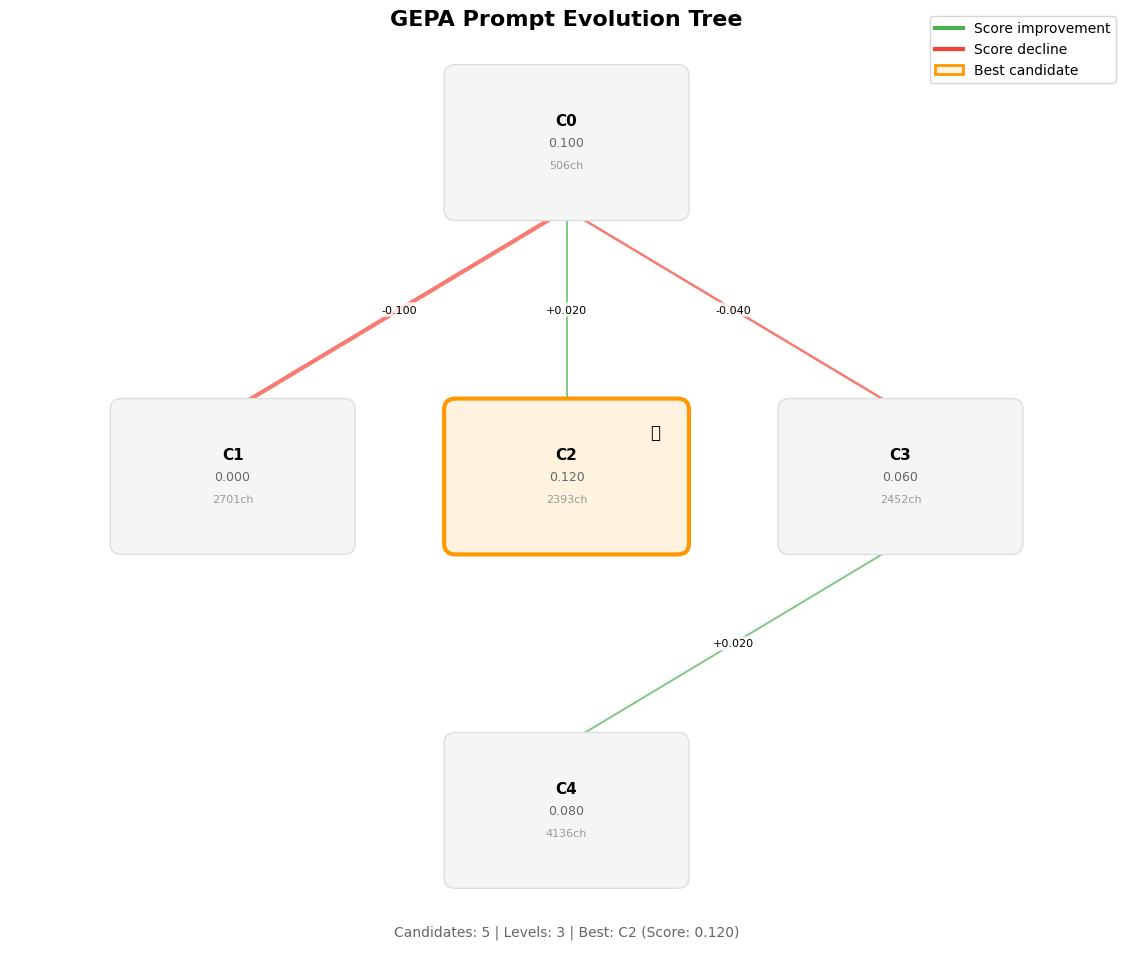

Evolution tree saved to: evolution_tree.png


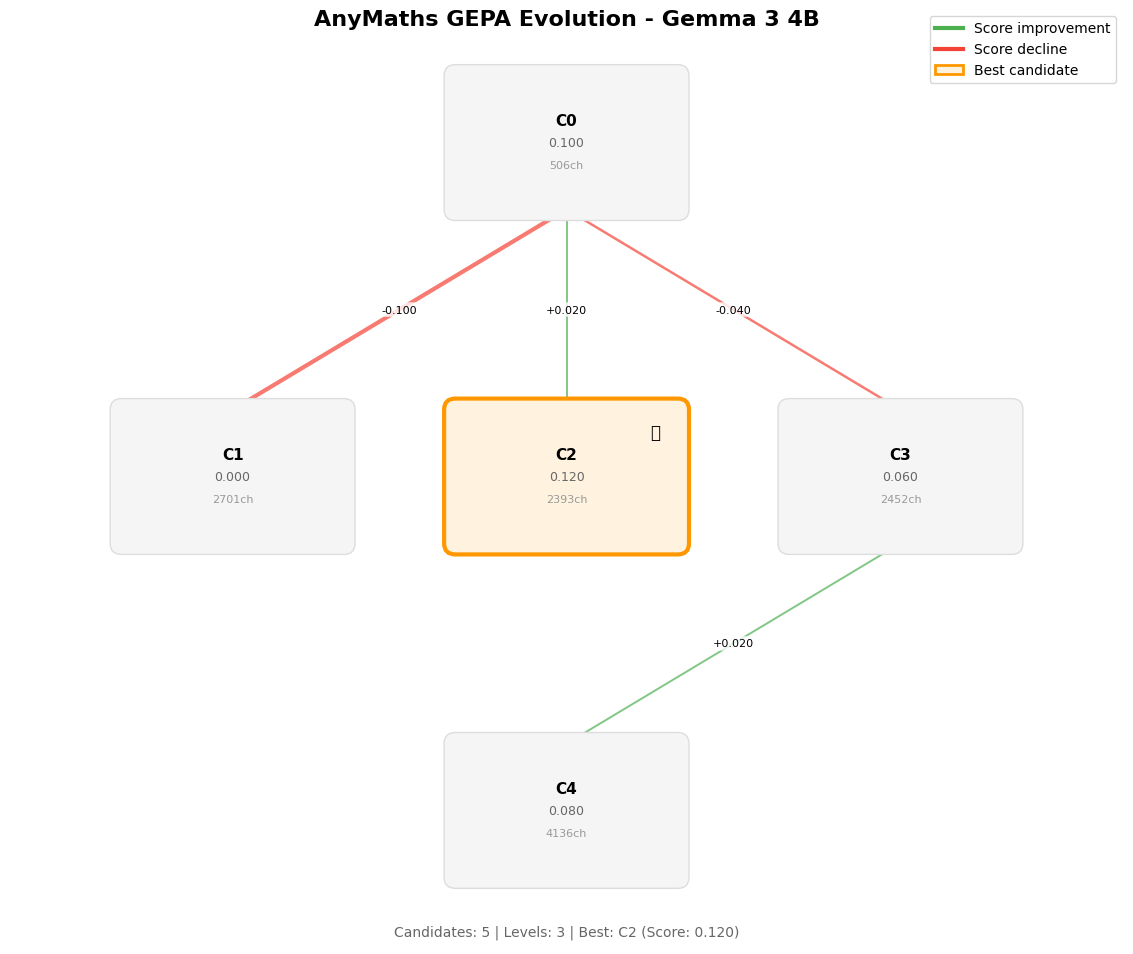

In [10]:
# Using your existing optimized_results from bench_maths.ipynb
#optimized_results_dict = optimized_results.to_dict()

# Complete analysis with visualization
fig = analyze_gepa_results(
    optimized_results_dict,
    save_path="gepa_evolution_tree.png",
    show_plot=True
)

# Or just the plot
fig = plot_gepa_evolution_tree(
    optimized_results_dict,
    title="AnyMaths GEPA Evolution - Gemma 3 4B",
    save_path="evolution_tree.png"
)